# Try Xarray

Derived from...
* http://xarray.pydata.org/en/stable/
* https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa
* https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f


## Read the NetCDF Dataset as Xarray object

- Import requrired modules/packages
- Scan for NC files in /data folder
- Open a sample NC file & explore groups, dimensions, variables
- 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

# define config constant (to be parms in code)
data_path = "../data/"
netCDF_extension = "nc"

In [2]:
data = xr.DataArray(np.random.randn(2, 3), dims=('x', 'y'), coords={'x': [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.60309655,  1.71451747,  0.41833695],
       [-0.26977813,  1.51762286,  0.03571842]])
Coordinates:
  * x        (x) int32 10 20
Dimensions without coordinates: y

In [3]:
ds = xr.open_dataset(data_path + 'tornado3d' + '.' + netCDF_extension)
ds

<xarray.Dataset>
Dimensions:  (xdim: 128, ydim: 128, zdim: 128)
Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
Data variables:
    u        (zdim, ydim, xdim) float32 ...
    v        (zdim, ydim, xdim) float32 ...
    w        (zdim, ydim, xdim) float32 ...
Attributes:
    creation_date:  16-Apr-2019 17:36:10
    grid:           regular

In [4]:
ds.coords

Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0

In [5]:
ds.dims

Frozen(SortedKeysDict({'zdim': 128, 'ydim': 128, 'xdim': 128}))

In [6]:
ds.attrs

{'creation_date': '16-Apr-2019 17:36:10', 'grid': 'regular'}

In [7]:
# try converting to pandas dataframe  
# NOTE: actually bound conversion method to object, rather than converting

df = ds.to_dataframe
df

<bound method Dataset.to_dataframe of <xarray.Dataset>
Dimensions:  (xdim: 128, ydim: 128, zdim: 128)
Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
Data variables:
    u        (zdim, ydim, xdim) float32 ...
    v        (zdim, ydim, xdim) float32 ...
    w        (zdim, ydim, xdim) float32 ...
Attributes:
    creation_date:  16-Apr-2019 17:36:10
    grid:           regular>

## Reshape CDF variables

Have 3 variables (u,v,w) each with shape = (128,128,128). Need one array of shape (128,128,128,3).

In [8]:
# start with simple example...

size = 8

(u, v, w) = (np.random.randint(0,100,(size,size,size)), ) * 3
print('v shape = ', u.shape)

# combine with np.stack making the new dimension the last
uvw = np.stack((u, v, w), axis=-1)
print('uvw shape = ', uvw.shape)
print('total cells are ', np.prod(uvw.shape))   # uvw.shape

v shape =  (8, 8, 8)
uvw shape =  (8, 8, 8, 3)
total cells are  1536


In [9]:
# Are the cells of u & v & w the same as  uvw(i,i,i,:)

for i in range(size): print((u[i,i,i], v[i,i,i], w[i,i,i]), 'when stacked... ', uvw[i,i,i,:])

(25, 25, 25) when stacked...  [25 25 25]
(89, 89, 89) when stacked...  [89 89 89]
(79, 79, 79) when stacked...  [79 79 79]
(53, 53, 53) when stacked...  [53 53 53]
(23, 23, 23) when stacked...  [23 23 23]
(22, 22, 22) when stacked...  [22 22 22]
(16, 16, 16) when stacked...  [16 16 16]
(31, 31, 31) when stacked...  [31 31 31]


## Set np.arrays for u,v,w from our sample netCDL dataset

In [10]:
u = np.array(ds.data_vars['u'])
v = np.array(ds.data_vars['v'])
w = np.array(ds.data_vars['w'])
u.shape

(128, 128, 128)

## Combine three variable into one using np.stack

In [11]:
# combine with np.stack making the new dimension the last

uvw = np.stack((u, v, w), axis=-1)
print('uvw shape = ', uvw.shape)
print('total cells are ', np.prod(uvw.shape))   # uvw.shape

uvw shape =  (128, 128, 128, 3)
total cells are  6291456


## Find min-max of u-v-w velocities

In [12]:
uvw_min = np.amin(uvw)
uvw_min

-6.2111263

In [13]:
uvw_max = np.amax(uvw)
uvw_max

6.2132716

## Show the distribution of initial U-V-W values

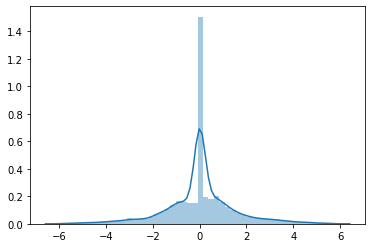

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Since >6M cells, random sample for efficiency
uvw_sample = np.random.choice(np.ndarray.flatten(uvw), 10**4)
uvw_sampleU = np.random.choice(np.ndarray.flatten(uvw[:,:,:,0]), 10**4)
uvw_sampleV = np.random.choice(np.ndarray.flatten(uvw[:,:,:,1]), 10**4)
uvw_sampleW = np.random.choice(np.ndarray.flatten(uvw[:,:,:,2]), 10**4)

sns.distplot(uvw_sample)

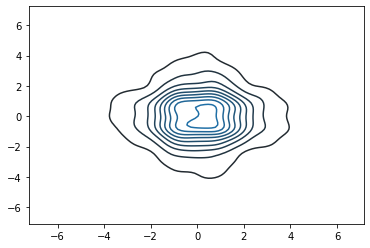

In [78]:
sns.kdeplot(uvw_sampleU, uvw_sampleV)

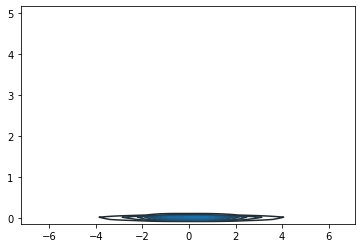

In [79]:
sns.kdeplot(uvw_sampleU, uvw_sampleW)

## Normalize and scale 255 for RGB color

using x_norm = 256*(X-uvw_min)/(uvw_max-uvw_min)

In [14]:
uvw_norm = (255 * (uvw / (uvw_max-uvw_min) - (uvw_min/(uvw_max-uvw_min)))).astype(np.int)
uvw_norm[:2,:2,:2,:]

array([[[[125,  87, 127],
         [126,  87, 127]],

        [[125,  87, 127],
         [126,  87, 127]]],


       [[[123,  88, 127],
         [124,  87, 127]],

        [[124,  87, 127],
         [125,  87, 127]]]])

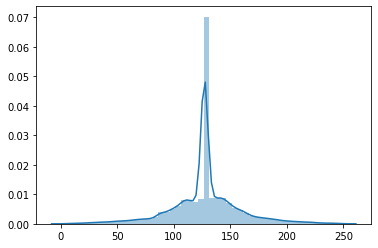

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Since >6M cells, random sample for efficiency
uvw_sample = np.random.choice(np.ndarray.flatten(uvw_norm), 10**4)
sns.distplot(uvw_sample)

## Save UVW_norm to /Data 

In [16]:
file_name = "../Data/tornado3d_norm.npy"  # add timestamp in future
np.save(file_name, uvw_norm)  #### interesting... NPY file is same size as orginal NC file

### uvw_norm = np.load(file_name)    # uncomment when needed

## Create color pixels from truples (R,G,B)

In [17]:
from PIL import Image

In [39]:
(r,g,b) = uvw_norm

ValueError: too many values to unpack (expected 3)

In [43]:
# METHOD A - simple calculation

(r,g,b) = uvw_norm[1,1,1,:]
print((r,g,b))
rgb = 256**2 * r + 256 * g + b
print(rgb)
rr = rgb // 256**2

(125, 87, 127)
8214399


125

In [56]:
# Method B - packing bytes in hex
import struct

rgb = uvw_norm[1,1,1,:]
print(rgb)
rgb_hex = bytes.hex(struct.pack('BBB',*rgb))
int(rgb_hex, 16)

[125  87 127]


8214399

In [47]:
R = uvw_norm[:,:,:,0]
G = uvw_norm[:,:,:,1]
B = uvw_norm[:,:,:,2]
RGB = ((256**2) * R) + (256 * G) + B
RGB.shape
RGB[1,1,1]

8214399

In [ ]:

u_norm2D = uvw_norm[i,:,:,0]

uvw_norm2D = uvw_norm[i,:,:,0]


# n = r256^2 + g256 + b

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

#plt.ioff()  # when all the images are generated 
matplotlib.use('Agg')

(no_slices,_,_,_) = uvw_norm.shape
for i in range(no_slices):
    U = uvw[i,:,:,0]
    V = uvw[i,:,:,1]
    W = uvw[i,:,:,2]

    fig = plt.figure(figsize=(12,5))
    a = fig.add_subplot(1,4,1)
    plt.imshow(U, cmap='seismic')
    a.set_title('U')
    plt.colorbar(orientation='horizontal')

    a = fig.add_subplot(1,4,2)
    plt.imshow(V, cmap='seismic')
    a.set_title('V')
    plt.colorbar(orientation='horizontal')

    a = fig.add_subplot(1,4,3)
    plt.imshow(W, cmap='seismic')
    a.set_title('W')
    plt.colorbar(orientation='horizontal')
    
    # Actually not needed here......  Will be for create 3D image 
    R = uvw_norm[i,:,:,0]
    G = uvw_norm[i,:,:,1]
    B = uvw_norm[i,:,:,2]
    RGB = (256**2 * R) + (256 * G) + B
    #print(R.shape, RGB.shape)
    
    a = fig.add_subplot(1,4,4)
    plt.imshow(uvw_norm[i,:,:,:])
    rgb_title = 'RGB_Slice{:04d}'.format(i)
    a.set_title(rgb_title)
    plt.colorbar(orientation='horizontal')

    plt.savefig('log/' + rgb_title)

#plt.imshow(uvw_image)


#uvw_image = Image.fromarray(u_norm2D)
#print(uvw_image)
#uvw_image = Image.new(im.mode, im.size)
#uvw_image = Image 

#plt.imshow(uvw_image, mode=None)


## Generate animated GIF from RGB Slice in /log

In [73]:
import glob
import imageio
from PIL import Image

anim_file = 'log/RGB_slices.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('log/RGB_slice*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

AttributeError: 'function' object has no attribute 'Image'

## Generate 3D image from UVW

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


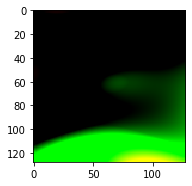

In [127]:
# try simple imshow images
# from https://matplotlib.org/3.2.1/tutorials/introductory/images.html and 
import matplotlib.pyplot as plt

fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(lum_img)
a.set_title('Before')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(lum_img)
imgplot.set_clim(0.0, 0.7)
a.set_title('After')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')


i = 1
plt.imshow(uvw[:,:,i,:])


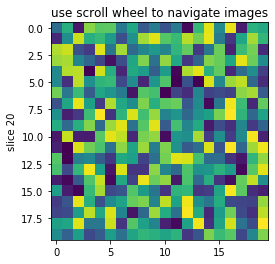

In [128]:
# Image Slicer Viewer
# from https://matplotlib.org/gallery/animation/image_slices_viewer.html

import numpy as np
import matplotlib.pyplot as plt


class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.random.rand(20, 20, 40)

tracker = IndexTracker(ax, X)
#tracker = IndexTracker(ax, )


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

3D quiver plot -- Demonstrates plotting directional arrows at points on a 3d meshgrid.
from https://matplotlib.org/3.2.1/gallery/mplot3d/quiver3d.html

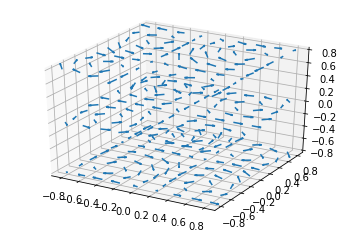

In [114]:
# %matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.8))

# Make the direction data for the arrows
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)

plt.show()

In [108]:
# try pillow 
import pillow

ModuleNotFoundError: No module named 'pillow'

In [ ]:
################ References
# https://matplotlib.org/3.1.1/gallery/mplot3d/voxels.html  An easy introduction to 3D plotting with Matplotlib
# 

## Define function to list all files in directory with a specific extension (for later)

In [24]:


def list_files(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))

# List each nc file with its creation data and variables
for f in list_files(data_path, netCDF_extension):
    print(f)
    nc = Dataset(data_path + f, "r")
    nc_dict = nc.__dict__
    cdate = nc_dict['creation_date']
    vars = 
    print(f"{f} created {cdate} with variables {vars}")


tornado3d.nc
tornado3d.nc created 16-Apr-2019 17:36:10
